In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
from os import listdir
from os.path import isfile, join
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
%cd drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning


[Errno 2] No such file or directory: 'drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning'
/content/drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning


In [36]:
!ls

DataSets  DEMO-Vision


In [37]:
fpath_C = './DataSets/MonoCristal/Train-Val/'


In [41]:

files_C = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_C)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]

ROI_C = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_C)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' in name)]





fname = files_C[-2]
print(fname)
print(len(files_C),len(ROI_C))


./DataSets/MonoCristal/Train-Val/Validation/Txarrak/1118.jpg
320 396


./DataSets/MonoCristal/Train-Val/Train/Txarrak/1052.jpg


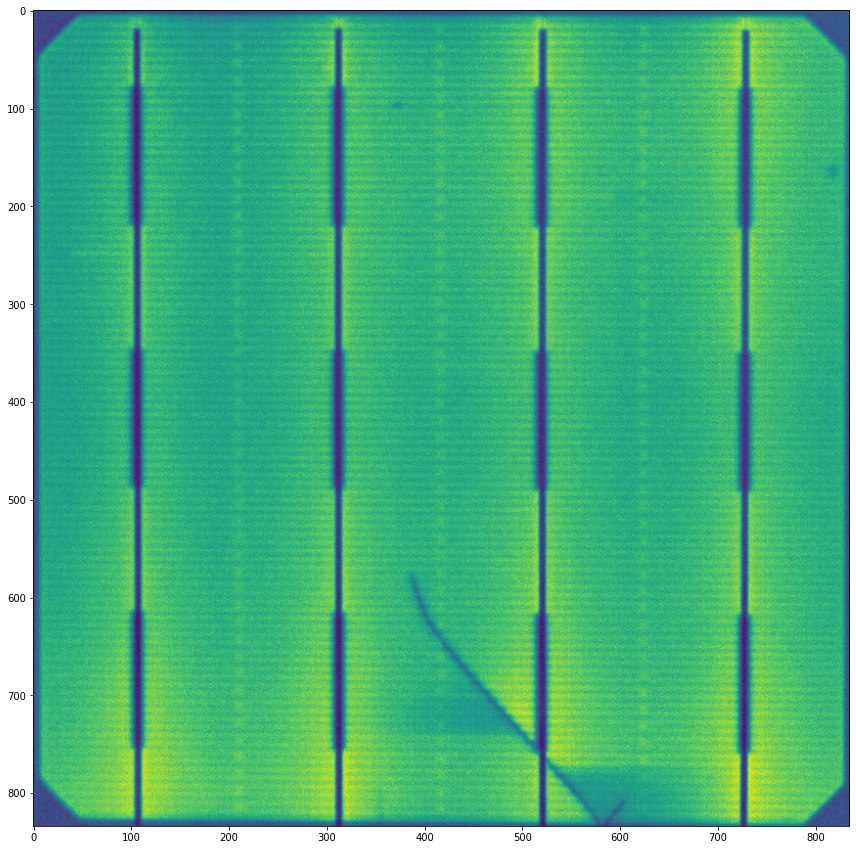

In [42]:
fname = files_C[57]
print(fname)
img = cv2.imread(fname,0)

plt.figure(figsize=(15, 15))
#plt.subplot(221)
plt.imshow(img)
plt.show()

In [43]:
#Create directories for training data generation

pth = "./data_mono"
os.mkdir(pth)

#target_path = "./data_poly_64_prueba/train"
target_path = pth + "/train"
try:
    os.stat(target_path)
except:
    os.mkdir(target_path)
try:
    os.stat(target_path+'/bad')
except:
    os.mkdir(target_path+'/bad')
try:
    os.stat(target_path+'/good')
except:
    os.mkdir(target_path+'/good')
    
from random import randint
import shutil

#valid_path = "./data_poly_64_prueba/validation"
valid_path = pth + "/validation"
try:
    os.stat(valid_path)
except:
    os.mkdir(valid_path)
try:
    os.stat(valid_path+'/bad')
except:
    os.mkdir(valid_path+'/bad')
try:
    os.stat(valid_path+'/good')
except:
    os.mkdir(valid_path+'/good')


In [44]:
!ls

data_mono  DataSets  DEMO-Vision  ExerciseFV


In [45]:
#--------------------------------------
### IMAGE PROCESSING && SAVING
def img_procc(fname, tgt_folder,type='bad'):
    new_w = 64 #256 #128 #64 # 150
    new_h = 64 #256 #128 #64 # 150
    overlap = 0.5
    tki,tkj = 5, 5 # take 1 out of 4 images
    cnti,cntj = 5, 5
    
    img = cv2.imread(fname,0)
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = img*1./255
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    img_ROI = []
    
    #DEFINE SAVE PATH
    ROI=find_ROI_img(fname)
    #print(ROI[0])
    if ROI!=None:
        img_ROI = cv2.imread(ROI[0],0) 
        img_ROI = 1-(img_ROI/255)
    
    w_len = 0
    for i,vali in enumerate(range(0,img_w,int(new_w - overlap*new_w))):
        cnti=cnti+1
        if cnti>tki:
            cnti = 0
            h_len = 0 
            if w_len != 1: #NO estamos en la esquina de la figura
                for j,valj in enumerate(range(0,img_h,int(new_h - overlap*new_h))):
                    cntj=cntj+1
                    if cntj>tkj:
                        cntj = 0
                        if h_len != 1: # NO estamos en la esquina de la figura
                            #take img
                            w_rng = [vali, vali+new_w]
                            h_rng = [valj, valj+new_h]
                            if (vali+new_w > img_w):
                                w_len=1 #estamos en la esquina de la figura
                                w_rng = [img_w-new_w, img_w]
                            if (valj+new_h > img_h):
                                h_len=1    
                                h_rng = [img_h-new_h, img_h]

                            new_img = img[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]

                            otro = 0 #para generar otras copias en errores

                            if ROI==None:
                                #overlap = 0.3
                                dnm,fnm = os.path.split(fname)
                                nw_fname = target_path + '/good/G_' + os.path.splitext(fnm)[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(fnm)[1]
                            else:
                                dnm,fnm = os.path.split(fname)
                                nw_fname = target_path + '/good/B_' + os.path.splitext(fnm)[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(fnm)[1]

                                img_ROI_tmp = img_ROI[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                                if img_ROI_tmp.sum()>100:
                                    otro = 1
                                    cnti = tki+2 #para que coja los errores más veces que los que no.
                                    cntj = tkj+2 
                                    #overlap = 0.6
                                    nw_fname = target_path + '/' + type + '/B_' + os.path.splitext(ROI[1])[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(ROI[1])[1]

                            cv2.imwrite(nw_fname, new_img) 
                            # 90 degree rotated
                            nw_fname_90 = nw_fname[:-4]+'_90'+ nw_fname[-4:]
                            rows,cols = new_img.shape
                            M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
                            dst1 = cv2.warpAffine(new_img,M,(cols,rows))
                            cv2.imwrite(nw_fname_90, dst1)

                            if otro:
                                dst2 = cv2.warpAffine(dst1,M,(cols,rows))
                                nw_fname_180 = nw_fname[:-4]+'_180'+ nw_fname[-4:]
                                cv2.imwrite(nw_fname_180, dst2)
                                dst3 = cv2.warpAffine(dst2,M,(cols,rows))
                                nw_fname_270 = nw_fname[:-4]+'_270'+ nw_fname[-4:]
                                cv2.imwrite(nw_fname_270, dst3)


                            #cv2.imwrite(nw_fname_90, new_img.transpose())
                            #print("Save:: " + nw_fname)
                            #print(w_rng, h_rng)
                            #print(i,j,vali,valj)

def find_ROI_img(fname):
    dnm,fnm = os.path.split(fname)
    ROI_fnm = os.path.splitext(fnm)[0]+'_ROI_Mono2.bmp'  
    ROI_pth = os.path.join(dnm,ROI_fnm)
    if os.path.isfile(ROI_pth):
        return ROI_pth,fnm


In [ ]:
np.ones((4,5)).sum()

20.0

In [46]:
fname = files_C[3]
ROI=find_ROI_img(fname)
print(fname)
print(ROI)

./DataSets/MonoCristal/Train-Val/Train/Txarrak/1016.jpg
('./DataSets/MonoCristal/Train-Val/Train/Txarrak/1016_ROI_Mono2.bmp', '1016.jpg')


In [47]:
bmpfiles = files_C
for i,fname in enumerate(bmpfiles):
    print('PROCESSING:: ' + str(i) + ' :: ' + fname)
    #fname = bmpfiles[-10]
    try:
        img_procc(fname, target_path)
    except:
        #print(" ")
        print("Exception occurred with : " + fname)
    time.sleep(0.01)

PROCESSING:: 0 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1005.jpg
PROCESSING:: 1 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1001.jpg
PROCESSING:: 2 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1002.jpg
PROCESSING:: 3 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1016.jpg
PROCESSING:: 4 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1017.jpg
PROCESSING:: 5 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1004.jpg
PROCESSING:: 6 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1003.jpg
PROCESSING:: 7 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1006.jpg
PROCESSING:: 8 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1020.jpg
PROCESSING:: 9 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1021.jpg
PROCESSING:: 10 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1018.jpg
PROCESSING:: 11 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1023.jpg
PROCESSING:: 12 :: ./DataSets/MonoCristal/Train-Val/Train/Txarrak/1019.jpg
PROCESSING:: 13 :: ./DataSets/MonoC

In [48]:
## MOVE SOME FILES TO VALIDATION SET
newfiles = [os.path.join(root, name).replace('\\','/')
             for root, dirs, files in os.walk(target_path)
             for name in files
             if name.endswith((".jpg", ".JPG"))]

len_files = len(newfiles)
validation_l = round(len_files/10)


x=[randint(0,len_files) for p in range(0,validation_l)]
x = list(set(x)) #take unique filenames
for val in x:
    shutil.move(newfiles[val],newfiles[val].replace("train", "validation"))



In [49]:
pth_Train_G = './data_mono/train/good'
pth_Train_B = './data_mono/train/bad'

pth_Val_G = './data_mono/validation/good'
pth_Val_B = './data_mono/validation/bad'

Train_G = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Train_G)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]
Train_B = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Train_B)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]

Val_G = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Val_G)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]
Val_B = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Val_B)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]


print('Train::')
print(len(Train_G),len(Train_B))

print('')
print('Validation::')
print(len(Val_G),len(Val_B))

Train::
14088 1573

Validation::
1490 159
